In [1]:
import pandas as pd
import numpy as np

from collections import OrderedDict

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn import set_config

import prince

set_config(display='diagram')

In [2]:
df_all = pd.read_csv('../data/processed/0.3-feature-processing.csv', index_col=0)
df = df_all[df_all['year'] > 1960]

In [3]:
df = df.sort_values(by=['date']).reset_index(drop=True)

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (0.12% inertia)', ylabel='Component 1 (0.11% inertia)'>

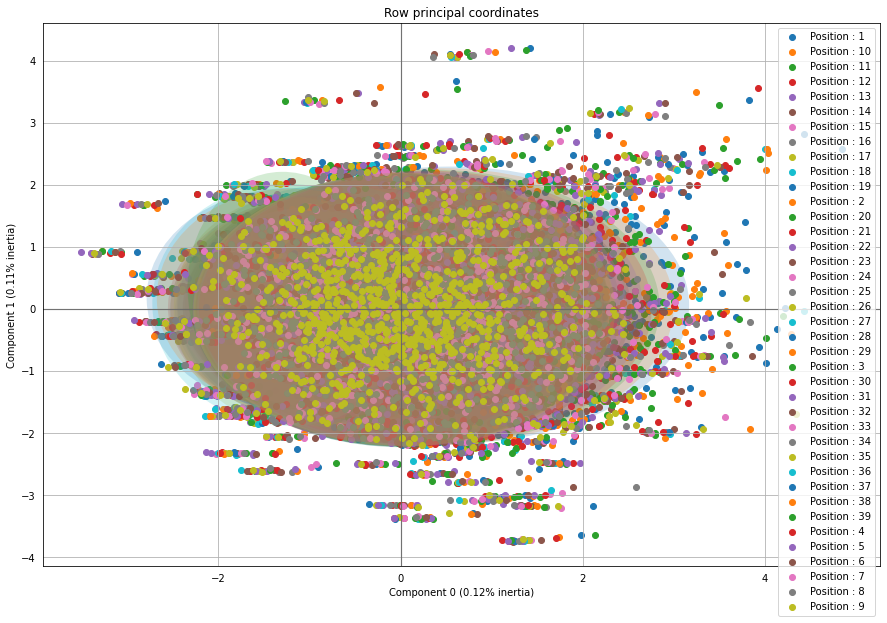

In [4]:
famd = prince.FAMD(n_components = 2, n_iter = 3, random_state = 42)

famd.fit(df)
famd.transform(df)
famd.plot_row_coordinates(df,figsize=(15, 10),color_labels=['Position : {}'.format(t) for t in df['positionOrder']] )

In [5]:
one_hot_encoder = ColumnTransformer([
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), ['driverId','circuitId','constructorId'])], 
    remainder='passthrough')

In [6]:
pipeline = Pipeline([
    ('one_hot', one_hot_encoder),
    # ('scaller', StandardScaler(with_mean=False)),
    # ('pca', PCA()),
    ('model', Ridge(random_state=42))
])
param_grid = {
    'model__alpha':[0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1],
}

In [7]:
pipeline

Pipeline(steps=[('one_hot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['driverId', 'circuitId',
                                                   'constructorId'])])),
                ('model', Ridge(random_state=42))])

In [8]:
pipeline.get_params()

{'memory': None,
 'steps': [('one_hot',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('one_hot',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore'),
                                    ['driverId', 'circuitId', 'constructorId'])])),
  ('model', Ridge(random_state=42))],
 'verbose': False,
 'one_hot': ColumnTransformer(remainder='passthrough',
                   transformers=[('one_hot',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['driverId', 'circuitId', 'constructorId'])]),
 'model': Ridge(random_state=42),
 'one_hot__n_jobs': None,
 'one_hot__remainder': 'passthrough',
 'one_hot__sparse_threshold': 0.3,
 'one_hot__transformer_weights': None,
 'one_hot__transformers': [('one_hot',
   OneHotEncoder(drop='first', handle_unknown='ignore'),
 

In [9]:
X = df[df.columns.difference(['positionOrder', 'date', 'round', 'year'])]
# X = df[['gridStart','lastRaceRank']]
y = df['positionOrder']

tscv = TimeSeriesSplit(n_splits=5, test_size=20)

# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

model = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    cv=tscv,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)
model.fit(X,y)

print('Best parameters:\n', model.best_params_)
print('Best mean score in cross-validation:\n', round(model.best_score_,3))


Fitting 5 folds for each of 11 candidates, totalling 55 fits


/Users/marius/miniforge3/envs/machine-learning/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/marius/miniforge3/envs/machine-learning/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/marius/miniforge3/envs/machine-learning/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/marius/miniforge3/envs/machine-learning/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as

Best parameters:
 {'model__alpha': 0.2}
Best mean score in cross-validation:
 -15.731


In [20]:
random_forest_pipeline = Pipeline([
    ('one_hot', one_hot_encoder),
    # ('scaller', StandardScaler(with_mean=False)),
    # ('pca', PCA()),
    ('model', RandomForestRegressor(random_state=42))
])

random_forest = GridSearchCV(
    estimator = random_forest_pipeline,
    param_grid = {
        'model__max_depth':[2,3,5,7,10,None],
        'model__min_samples_split':[2,3,5],
        'model__min_samples_leaf': [2,3,4,6,10],
        'model__n_estimators':[100],
        'model__max_features':['auto'],
    },
    cv=tscv,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)
random_forest.fit(X,y)

print('Best parameters:\n', random_forest.best_params_)
print('Best mean score in cross-validation:\n', round(random_forest.best_score_,3))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/Users/marius/miniforge3/envs/machine-learning/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/marius/miniforge3/envs/machine-learning/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/marius/miniforge3/envs/machine-learning/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/marius/miniforge3/envs/machine-learning/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as

Best parameters:
 {'model__max_depth': 7, 'model__max_features': 'auto', 'model__min_samples_leaf': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best mean score in cross-validation:
 -15.932


In [11]:
df.columns

Index(['driverId', 'constructorId', 'gridStart', 'positionOrder', 'year',
       'round', 'circuitId', 'date', 'ageAtRace', 'ageAtDebut',
       'yearsExperience', 'racingAtHome', 'driverStandingsPoints',
       'driverStandingsPosition', 'driverStandingsWins', 'lastRaceRank',
       'constructorStandingsPoints', 'constructorStandingsPosition',
       'constructorStandingsWins', 'previousRaceGridStart',
       'previousRacePosition', 'racesWon', 'racesRetired', 'racesFinished',
       'polePositions', 'racesWonByConstructor', 'racesRetiredByConstructor',
       'percentageOfBestQuali'],
      dtype='object')

In [12]:
one_hot_columns = ['driverId','circuitId']

In [13]:
df = df[['gridStart','year','round','positionOrder']]

In [14]:
df_train=df[(df['year'] <= 2021) & (df['round']<19)]
df_validation=df[(df['year'] == 2021) & (df['round']==19)]

In [15]:
df_train.head(3)

,gridStart,year,round,positionOrder
0,4,1961,1,16
1,22,1961,1,21
2,22,1961,1,18


In [16]:
reg = LinearRegression().fit(df_train.iloc[:,:-3], df_train.iloc[:,-1:])
reg.score(df_train.iloc[:,:-3], df_train.iloc[:,-1:])

0.3204356522436782

In [17]:
prediction = reg.predict(df_validation.iloc[:,:-3])
df_prediction = pd.DataFrame(data=prediction,columns=['predictedOrder'])
df_validation = df_validation.reset_index(drop=True)

In [18]:
df_compare = pd.concat([df_validation, df_prediction], axis=1)

In [19]:
df_compare.head(20)

,gridStart,year,round,positionOrder,predictedOrder
0,7,2021,19,7,9.545496
1,6,2021,19,5,8.952550
2,5,2021,19,10,8.359603
3,17,2021,19,13,15.474959
4,19,2021,19,17,16.660852
5,15,2021,19,15,14.289067
6,18,2021,19,18,16.067906
7,14,2021,19,20,13.696120
8,16,2021,19,16,14.882013
9,13,2021,19,14,13.103174
